# Neuer Ansatz für die Trackingreferenz

Der Ansatz mit den Objektumgrenzungen und der Schnittfläche/Gesamtfläche ist wahrscheinlich zu objektlastig und keine gute Referenz. Ein möglicher neuer Ansatz wäre:

1. Anzahl sich überschneidende Pixel / Anzahl gemeinsamer Pixel statt Umgrenzungen, da die Umgrenzungen bei diagonalen sehr lang gestreckten Objekten unverhältnismäßig groß werden
2. die Metrik so umzuformen, dass keine Bewegung den schlechtesten Wert ergibt und eine vollständige Überlappung zwischen der veschobenen Wolke und der tatsächlich vorhandenen Wolke den besten Wert hat.
3. sich von einer Objektdefinition zu lösen, aber wie?

Zum Ausprobieren erstellen wir uns einfache Beispiele.

In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.append("/vols/talos/home/stephan/utils/tracking")
import cross_correlation_tracking as cct
import optical_flow_tracking as oft
import object_tracking as ot
import tracking_common as tco

params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)

/vols/talos/local/anaconda2-5.0.0/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
objekt_t0 = np.zeros((51,51))
objekt_t0[20:35,15:40] = 1
objekt_t0[15:25,30:40] = 1

In [3]:
objekt_t1 = np.zeros((51,51))
objekt_t1[15:27,20:48] = 1
objekt_t1[12:25,30:40] = 1

In [4]:
shift = cct.calc_cross_correlation_shift(objekt_t0,objekt_t1,cc_parameters={'box_size':51,'upsample_factor':1})

In [5]:
shift

array([[[ 8.,  8.,  8., ...,  8.,  8.,  8.],
        [ 8.,  8.,  8., ...,  8.,  8.,  8.],
        [ 8.,  8.,  8., ...,  8.,  8.,  8.],
        ...,
        [ 8.,  8.,  8., ...,  8.,  8.,  8.],
        [ 8.,  8.,  8., ...,  8.,  8.,  8.],
        [ 8.,  8.,  8., ...,  8.,  8.,  8.]],

       [[-8., -8., -8., ..., -8., -8., -8.],
        [-8., -8., -8., ..., -8., -8., -8.],
        [-8., -8., -8., ..., -8., -8., -8.],
        ...,
        [-8., -8., -8., ..., -8., -8., -8.],
        [-8., -8., -8., ..., -8., -8., -8.],
        [-8., -8., -8., ..., -8., -8., -8.]]])

In [6]:
objekt_t0_verschoben = tco.morph_field(objekt_t0,shift[0],shift[1])

Text(0.5,1,u'Objekt zu t1')

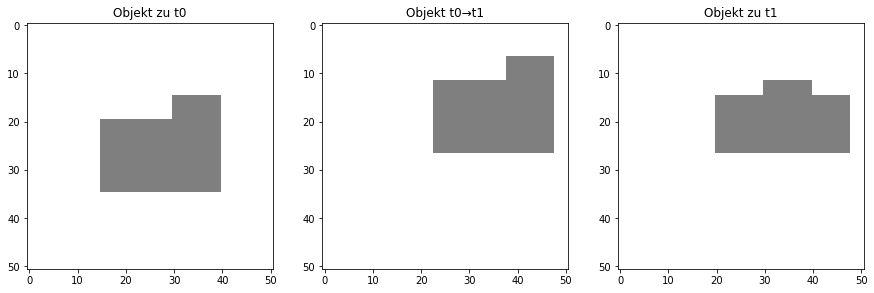

In [7]:
fig,ax = plt.subplots(1,3,figsize=(15,5))
ax[0].imshow(objekt_t0,vmin=0,vmax=2,cmap='gray_r')
ax[0].set_title(u"Objekt zu t0")

ax[1].imshow(objekt_t0_verschoben,vmin=0,vmax=2,cmap='gray_r')
ax[1].set_title(u"Objekt t0\u2192t1")

ax[2].imshow(objekt_t1,vmin=0,vmax=2,cmap='gray_r')
ax[2].set_title(u"Objekt zu t1")

Als nächstes sehen wir uns die Überscheneidung zwischen Objekt zu t0 und dem nach t1 verschobenen Objekt von t0 an.

In [8]:
ueberlapp0 = np.logical_and(objekt_t0, objekt_t0_verschoben)
vereinigung0 = np.logical_or(objekt_t0,objekt_t0_verschoben)

Text(0.5,1,u'Vereinigung t0 und t0\u2192t1')

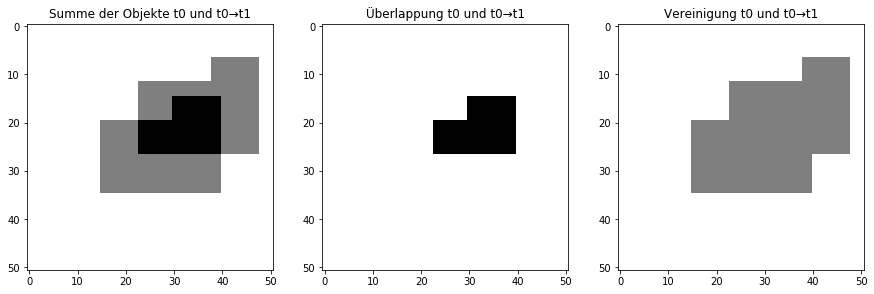

In [9]:
fig,ax = plt.subplots(1,3,figsize=(15,5))
ax[0].imshow(objekt_t0 + objekt_t0_verschoben,vmin=0,vmax=2,cmap='gray_r')
ax[0].set_title(u"Summe der Objekte t0 und t0\u2192t1")

ax[1].imshow(ueberlapp0,vmin=0,vmax=1,cmap='gray_r')
ax[1].set_title(u"Überlappung t0 und t0\u2192t1")

ax[2].imshow(vereinigung0,vmin=0,vmax=2,cmap='gray_r')
ax[2].set_title(u"Vereinigung t0 und t0\u2192t1")

Damit können wir das Verhältnis aus Überlappung und Vereinigung berechnen.


In [10]:
iou0 = np.where(ueberlapp0==1)[0].size / float(np.where(vereinigung0==1)[0].size)

print(u"Verhältnis aus Überlapp und Vereinigung = {:0.03f}".format(iou0))

Verhältnis aus Überlapp und Vereinigung = 0.248


In [11]:
print(u"Überlapp = {} px, Vereinigung = {} px".format(np.where(ueberlapp0==1)[0].size,
                                                      np.where(vereinigung0==1)[0].size))

Überlapp = 169 px, Vereinigung = 681 px


Wenn dieses Verhältnis 1 ist, hieße das, dass keine Verschiebung stattgefunden hätte. Das entspricht so nicht der Erwartung und ist deshalb als negativ zu bewerten. Das sich hier ergebende Verhältnis aus Überlappung und Vereinigung ist relativ klein, was positiv zu bewerten ist. Es hat also eine Verschiebung stattgefunden.

Das gleiche machen wir jetzt nochmal für das von t0 zu t1 verschobene Objekt und das Objekt zu t1.

In [12]:
ueberlapp1 = np.logical_and(objekt_t0_verschoben, objekt_t1)
vereinigung1 = np.logical_or(objekt_t0_verschoben,objekt_t1)

Text(0.5,1,u'Vereinigung Objekt t0\u2192t1, Objekt zu t1')

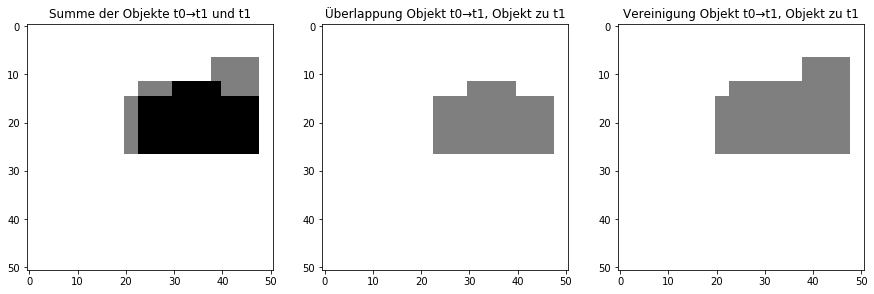

In [13]:
fig,ax = plt.subplots(1,3,figsize=(15,5))
ax[0].imshow(objekt_t0_verschoben + objekt_t1, vmin=0,vmax=2,cmap='gray_r')
ax[0].set_title(u"Summe der Objekte t0\u2192t1 und t1")

ax[1].imshow(ueberlapp1, vmin=0,vmax=2,cmap='gray_r')
ax[1].set_title(u"Überlappung Objekt t0\u2192t1, Objekt zu t1")

ax[2].imshow(vereinigung1, vmin=0,vmax=2,cmap='gray_r')
ax[2].set_title(u"Vereinigung Objekt t0\u2192t1, Objekt zu t1")

In [14]:
iou1 = np.where(ueberlapp1==1)[0].size / float(np.where(vereinigung1==1)[0].size)

print(u"Überlapp = {} px², Vereinigung = {} px²".format(np.where(ueberlapp1==1)[0].size,
                                                      np.where(vereinigung1==1)[0].size))
print(u"Verhältnis aus Überlapp und Vereinigung = {:0.03f}".format(iou1))

Überlapp = 330 px², Vereinigung = 461 px²
Verhältnis aus Überlapp und Vereinigung = 0.716


Hierbei bedeutet ein Wert von 1 eine perfekte Übereinstimmung und ist damit als positiv zu bewerten. Das Verhältnis ist relativ groß, was positiv zu bewerten ist.

## Differenz der Bewertungen
Als nächstes müssen wir die beiden Bewertungen verknüpfen. Die pragmatischste Variante wäre einfach IoU(t0,t0&rarr;t1) von IoU(t0&rarr;t1, t1) abzuziehen.

In [15]:
bewertung = iou1 - iou0

print(u"Gesamtbewertung = {:0.03f}".format(bewertung))

Gesamtbewertung = 0.468


Dabei würde ein Wert von -1 bedeuten, dass keine Bewegung stattgefunden hat, und es auch keine Überlappung mit dem Objekt des nächsten Zeitschrittes gibt. Der Wert 0 wurde bedeuten, dass beide Verhältnisse gleich groß sind. Ein Wert von 1 bedeutet, dass es eine relativ große Bewegung gegeben hat und keine Überlappung mehr mit dem Objekt zu t<sub>0</sub> da ist und die Überlappung mit dem Objekt zu t<sub>1</sub> perfekt ist.

Das funktioniert soweit gut, solange die Werte der IoU-Paare sich an 0,5 spiegeln. Das ist idealerweise der Fall, muss in der Wirklichkeit aber nicht so sein. Wenn das nicht so ist, ergeben ich Ambiguitäten.

In [16]:
iou0_bereich = np.arange(0,1.001,0.001)
iou1_bereich = np.arange(0,1.001,0.001)

In [17]:
differenz = np.zeros((iou0_bereich.size,iou1_bereich.size))
for i,i0 in enumerate(iou0_bereich):
    for j,i1 in enumerate(iou1_bereich):    
        differenz[j,i] = i1-i0

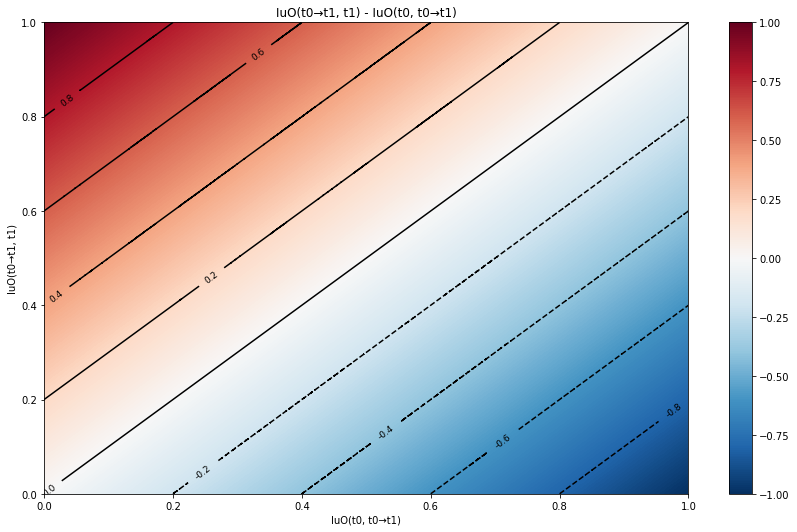

In [18]:
fig,ax = plt.subplots(1,1,figsize=(12,7.5))
bw_plot = ax.pcolormesh(iou0_bereich,iou1_bereich,differenz,vmin=-1,vmax=1,cmap='RdBu_r')
fig.colorbar(bw_plot,ax=ax)

bw_cont = ax.contour(iou0_bereich,iou1_bereich,differenz,10,colors='k',vmin=-1,vmax=1)
ax.clabel(bw_cont, fontsize=9, inline=1,fmt="%1.1f")
ax.set_xlabel(u"IuO(t0, t0\u2192t1)")
ax.set_ylabel(u"IuO(t0\u2192t1, t1)")
ax.set_title(u"IuO(t0\u2192t1, t1) - IuO(t0, t0\u2192t1)")

plt.tight_layout()
plt.savefig("/vols/talos/home/stephan/proj/2019-01_trackingstudie/pics/trackingreferenz_diagramm.png")

Wie hier zu sehen, kann ein Wert der Differenz von 0,5 durch mehrere Kombinationen zustande kommen, nämlich immer, wenn IoU(t<sub>0</sub>&rarr;t<sub>1</sub>, t<sub>1</sub>) = IoU(t<sub>0</sub>,t<sub>0</sub>&rarr;t<sub>1</sub>). Aber prinzipiell bedeutet ein Wert über 0 immer, dass die Überlappung mit dem nächsten Zeitschritt größer als die mit dem vorherigen Zeitschritt ist.

In [26]:
print(u"IoU(t0, t0\u2192t1) = {}".format(ot.pixel_intersection_over_union(objekt_t0,objekt_t0_verschoben)))
print(u"IoU(t0\u2192t1,t1) = {}".format(ot.pixel_intersection_over_union(objekt_t0_verschoben,objekt_t1)))
print(u"IoU(t0,t1) = {}".format(ot.pixel_intersection_over_union(objekt_t0,objekt_t1)))

IoU(t0, t0→t1) = 0.248164464023
IoU(t0→t1,t1) = 0.715835140998
IoU(t0,t1) = 0.316139767055


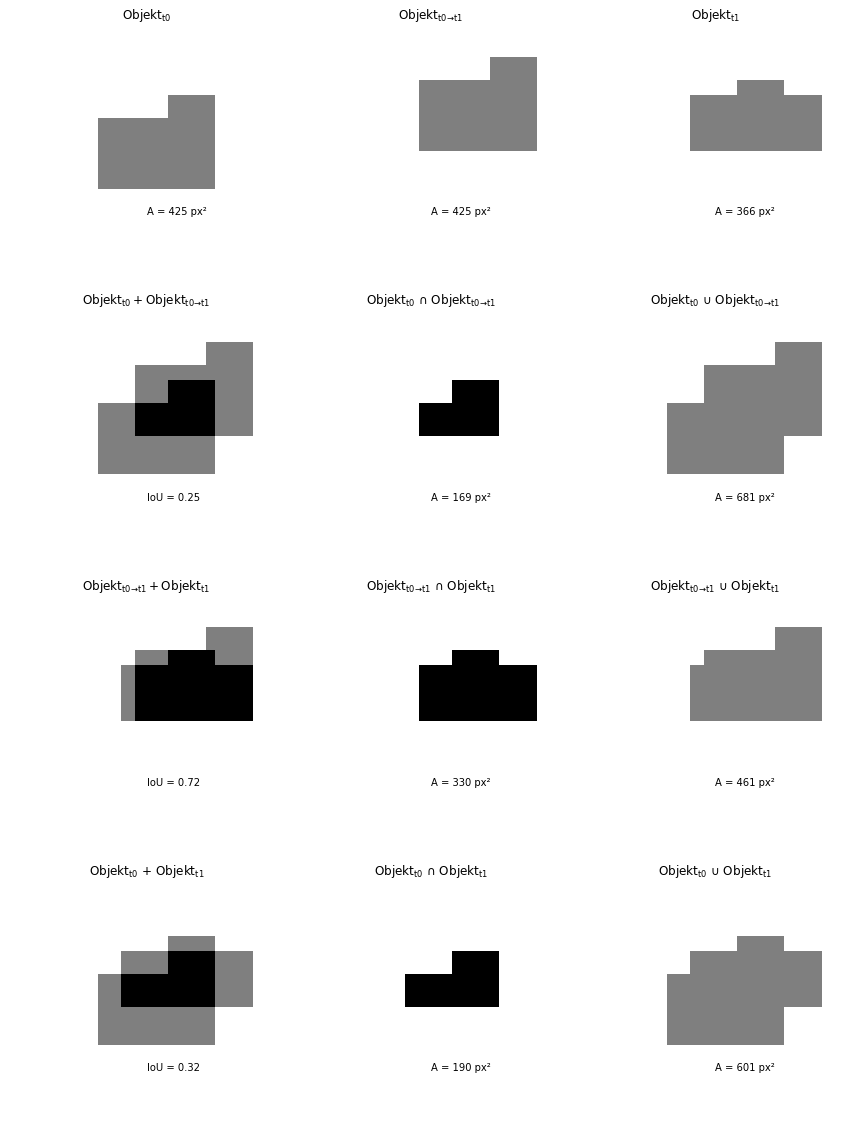

In [28]:
plt.rcParams.update(params)

fig,ax = plt.subplots(4,3,figsize=(12,16))
ax[0,0].imshow(objekt_t0,vmin=0,vmax=2,cmap='gray_r')
ax[0,0].set_title(u"Objekt$_{t0}$")
ax[0,0].set_axis_off()
ax[0,0].text(25,40,u"A = {:d} px²".format(np.where(objekt_t0==1)[0].size))

ax[0,1].imshow(objekt_t0_verschoben,vmin=0,vmax=2,cmap='gray_r')
ax[0,1].set_title(u"Objekt$_{t0\u2192t1}$")
ax[0,1].set_axis_off()
ax[0,1].text(25,40,u"A = {:d} px²".format(np.where(objekt_t0_verschoben==1)[0].size))

ax[0,2].imshow(objekt_t1,vmin=0,vmax=2,cmap='gray_r')
ax[0,2].set_title(u"Objekt$_{t1}$")
ax[0,2].set_axis_off()
ax[0,2].text(25,40,u"A = {:d} px²".format(np.where(objekt_t1==1)[0].size))

ax[1,0].imshow(objekt_t0 + objekt_t0_verschoben,vmin=0,vmax=2,cmap='gray_r')
ax[1,0].set_title(u"$Objekt_{t0} +  Objekt_{t0\u2192t1}$")
ax[1,0].set_axis_off()
ax[1,0].text(25,40,"IoU = {:1.02f}".format(ot.pixel_intersection_over_union(objekt_t0,objekt_t0_verschoben)))

ax[1,1].imshow(ueberlapp0,vmin=0,vmax=1,cmap='gray_r')
ax[1,1].set_title(u"$Objekt_{t0}$ ∩ $Objekt_{t0\u2192t1}$")
ax[1,1].set_axis_off()
ax[1,1].text(25,40,u"A = {:d} px²".format(np.where(ueberlapp0==1)[0].size))

ax[1,2].imshow(vereinigung0,vmin=0,vmax=2,cmap='gray_r')
ax[1,2].set_title(u"$Objekt_{t0}$ ∪ Objekt$_{t0\u2192t1}$")
ax[1,2].set_axis_off()
ax[1,2].text(25,40,u"A = {:d} px²".format(np.where(vereinigung0==1)[0].size))

ax[2,0].imshow(objekt_t0_verschoben + objekt_t1,vmin=0,vmax=2,cmap='gray_r')
ax[2,0].set_title(u"$Objekt_{t0\u2192t1} + Objekt_{t1}$")
ax[2,0].set_axis_off()
ax[2,0].text(25,40,"IoU = {:1.02f}".format(ot.pixel_intersection_over_union(objekt_t0_verschoben,objekt_t1)))

ax[2,1].imshow(ueberlapp1,vmin=0,vmax=1,cmap='gray_r')
ax[2,1].set_title(u"$Objekt_{t0\u2192t1}$ ∩ $Objekt_{t1}$")
ax[2,1].set_axis_off()
ax[2,1].text(25,40,u"A = {:d} px²".format(np.where(ueberlapp1==1)[0].size))

ax[2,2].imshow(vereinigung1,vmin=0,vmax=2,cmap='gray_r')
ax[2,2].set_title(u"$Objekt_{t0\u2192t1}$ ∪ $Objekt_{t1}$")
ax[2,2].set_axis_off()
ax[2,2].text(25,40,u"A = {:d} px²".format(np.where(vereinigung1==1)[0].size))

ax[3,0].imshow(objekt_t0 + objekt_t1,vmin=0,vmax=2,cmap='gray_r')
ax[3,0].set_title(u"Objekt$_{t0}$ + Objekt$_{t1}$")
ax[3,0].set_axis_off()
ax[3,0].text(25,40,"IoU = {:1.02f}".format(ot.pixel_intersection_over_union(objekt_t0,objekt_t1)))

ax[3,1].imshow(np.logical_and(objekt_t0,objekt_t1),vmin=0,vmax=1,cmap='gray_r')
ax[3,1].set_title(u"Objekt$_{t0}$ ∩ Objekt$_{t1}$")
ax[3,1].set_axis_off()
ax[3,1].text(25,40,u"A = {:d} px²".format(np.where(np.logical_and(objekt_t0,objekt_t1)==1)[0].size))

ax[3,2].imshow(np.logical_or(objekt_t0,objekt_t1),vmin=0,vmax=2,cmap='gray_r')
ax[3,2].set_title(u"Objekt$_{t0}$ ∪ Objekt$_{t1}$")
ax[3,2].set_axis_off()
ax[3,2].text(25,40,u"A = {:d} px²".format(np.where(np.logical_or(objekt_t0,objekt_t1)==1)[0].size))

plt.tight_layout()
plt.savefig("/vols/talos/home/stephan/proj/2019-01_trackingstudie/pics/trackingreferenzkonzept.pdf")

Vielleicht kann man diese Bewertung noch um einen Faktor für das Wachstum oder das Schrumpfen des Objektes erweitern. Bei der Betrachtung in Richtung Zukunft, sollte das Objekt wachsen und in Richtung Vergangenheit schrumpfen. Aber das muss nicht unbedingt so sein.

## Quotient der IoU-Wert

Eine weitere Möglichkeit ist es, den Quotienten aus Iou(t<sub>0</sub>&rarr;t<sub>1</sub>,t<sub>1</sub>) und IoU(t<sub>0</sub>, t<sub>0</sub>&rarr;t<sub>1</sub>) zu bilden. Der Quotient hat folgende Eigenschaften:

- $ \frac{\mathrm{IoU}(t_0,t_0\rightarrow t_1)}{\mathrm{IoU}(t_0\rightarrow t_1, t_1)} = 0$: IoU(t<sub>0</sub>&rarr;t<sub>1</sub>,t<sub>1</sub>) > 0,  IoU(t<sub>0</sub>, t<sub>0</sub>&rarr;t<sub>1</sub>) = 0,

- $ 0 < \frac{\mathrm{IoU}(t_0,t_0\rightarrow t_1)}{\mathrm{IoU}(t_0\rightarrow t_1, t_1)} < 0.5$: IoU(t<sub>0</sub>,t<sub>0</sub>&rarr;t<sub>1</sub>) > IoU(t<sub>0</sub>&rarr;t<sub>1</sub>, <sub>1</sub>)., 

- $\frac{\mathrm{IoU}(t_0,t_0\rightarrow t_1)}{\mathrm{IoU}(t_0\rightarrow t_1, t_1)} = 0.5$: IoU(t<sub>0</sub>&rarr;t<sub>1</sub>, t<sub>1</sub>) = IoU(t<sub>0</sub>, t<sub>0</sub>&rarr;t<sub>1</sub>),

- $0.5 < \frac{\mathrm{IoU}(t_0,t_0\rightarrow t_1)}{\mathrm{IoU}(t_0\rightarrow t_1, t_1)} \leq \infty$: IoU(t<sub>0</sub>,t<sub>0</sub>&rarr;t<sub>1</sub>) < IoU(t<sub>0</sub>&rarr;t<sub>1</sub>, <sub>1</sub>).

In [54]:
iou0_bereich2 = np.arange(0,1.01,0.01)
iou1_bereich2 = np.arange(0,1.01,0.01)

In [70]:
quotient = np.zeros((iou0_bereich.size,iou1_bereich.size))
for i,i0 in enumerate(iou0_bereich):
    for j,i1 in enumerate(iou1_bereich):    
        quotient[j,i] = i1/i0

/vols/talos/local/anaconda2-5.0.0/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.
/vols/talos/local/anaconda2-5.0.0/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  after removing the cwd from sys.path.


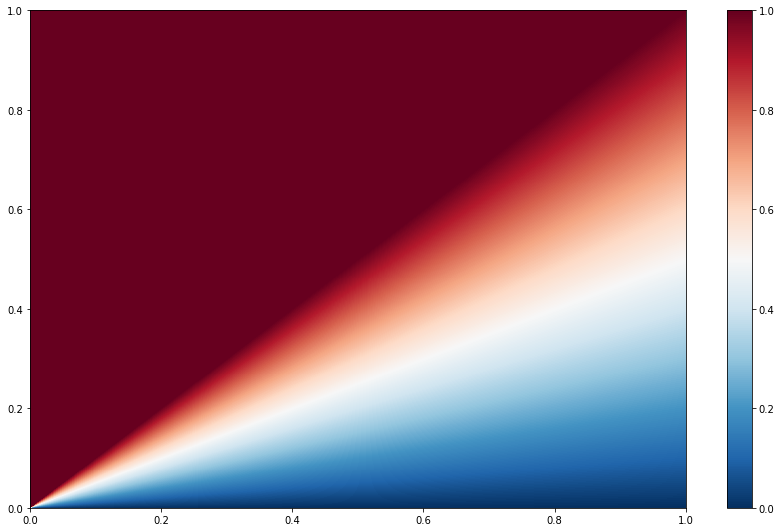

In [83]:
fig,ax = plt.subplots(1,1,figsize=(12,7.5))
bw_plot = ax.pcolormesh(iou0_bereich,iou1_bereich,np.ma.masked_invalid(quotient),vmin=0,vmax=1,cmap='RdBu_r')
fig.colorbar(bw_plot,ax=ax)

plt.tight_layout()
plt.savefig("/vols/talos/home/stephan/proj/2019-01_trackingstudie/pics/trackingreferenz_quotient_diagramm.png")

Die Verwendung des Quotienten führt dazu, dass es eine große Anzahl "guter" Werte gibt, während nur Werte unter 0,5 "schlecht" sind. Die "guten" Werte werden also stark überbetont.

Abhilfe könnte der Quotient aus den normalisierten Differenzen schaffen.

## Quotient der normalisierten Differenzen

Der Quotient aus den normalisierten Differenzen der IoU-Werte (NDII) berechnet sich folgendermaßen:

$$\mathrm{NIID} = \frac{\mathrm{IoU}(t_0\rightarrow t_1, t_1) - \mathrm{IoU}(t_0,t_0\rightarrow t_1)} {\mathrm{IoU}(t_0\rightarrow t_1, t_1) + \mathrm{IoU}(t_0,t_0\rightarrow t_1)} ; -1 \leq \mathrm{NIID} \leq 1$$

Der NIID hat folgende Eigenschaften:
IoU(t<sub>0</sub>&rarr;t<sub>1</sub>,t<sub>1</sub>)
IoU(t<sub>0</sub>, t<sub>0</sub>&rarr;t<sub>1</sub>)
- -1 &leq; NIID < 0: IoU(t<sub>0</sub>&rarr;t<sub>1</sub>,t<sub>1</sub>) < IoU(t<sub>0</sub>, t<sub>0</sub>&rarr;t<sub>1</sub>),
- NIID = 0:  IoU(t<sub>0</sub>&rarr;t<sub>1</sub>,t<sub>1</sub>) = IoU(t<sub>0</sub>, t<sub>0</sub>&rarr;t<sub>1</sub>),
- 0 < NIID &leq; 1: IoU(t<sub>0</sub>&rarr;t<sub>1</sub>,t<sub>1</sub>) > IoU(t<sub>0</sub>, t<sub>0</sub>&rarr;t<sub>1</sub>).

Das ist soweit gleich, wie bei der Differenz IoU(t<sub>0</sub>&rarr;t<sub>1</sub>,t<sub>1</sub>) - IoU(t<sub>0</sub>, t<sub>0</sub>&rarr;t<sub>1</sub>). Allerdings ist der NIID, anders als die Differenz, unabhängig davon, wie groß die einzelnen IoU Werte sind. Die Differenz kann die Werte -1 und 1 nur dann Annehmen, wenn einer der IoU-Werte 1 und der andere 0 ist. Der NIID kann auch bei weniger extremen IoU-Werten Werte nahe -1 oder 1 annehmen.

In [92]:
ndii = np.zeros((iou0_bereich.size,iou1_bereich.size))
for i,i0 in enumerate(iou0_bereich):
    for j,i1 in enumerate(iou1_bereich):    
        ndii[j,i] = (i1 - i0) / (i1 + i0)

/vols/talos/local/anaconda2-5.0.0/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.


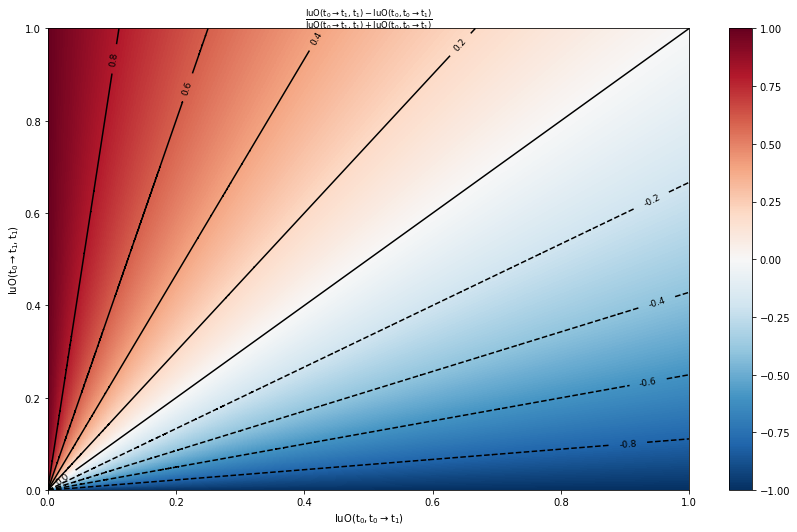

In [114]:
plt.rcParams.update(params)

fig,ax = plt.subplots(1,1,figsize=(12,7.5))
bw_plot = ax.pcolormesh(iou0_bereich,iou1_bereich,nid,vmin=-1,vmax=1,cmap='RdBu_r')
fig.colorbar(bw_plot,ax=ax)

bw_cont = ax.contour(iou0_bereich,iou1_bereich,nid,10,colors='k',vmin=-1,vmax=1)
ax.clabel(bw_cont, fontsize=9, inline=1,fmt="%1.1f")
ax.set_xlabel(r"$\mathrm{IuO}(t_0, t_0\rightarrow t_1)$")
ax.set_ylabel(r"$\mathrm{IuO}(t_0\rightarrow t_1,t_1)$")
ax.set_title(r"$\frac{\mathrm{IuO}(t_0\rightarrow t_1, t_1) - \mathrm{IuO}(t_0, t_0\rightarrow t_1)}{\mathrm{IuO}(t_0\rightarrow t_1, t_1) + \mathrm{IuO}(t_0, t_0\rightarrow t_1)}$")

plt.tight_layout()
plt.savefig("/vols/talos/home/stephan/proj/2019-01_trackingstudie/pics/trackingreferenz_ndii_diagramm.png")